# LSTM

In [37]:
import dlc_bci as bci
import torch
from torch.autograd import Variable
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = 8, 4

In [ ]:
def plot_learning_curves(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(8,4))
    plt.plot(train_losses, '--', c=c[0], label='Train loss')
    plt.plot(val_losses, c=c[0], label='Val loss')
    plt.legend(loc='best')
    
    plt.figure(figsize=(8,4))
    plt.plot(train_accs, '--', c=c[1], label='Train acc')
    plt.plot(val_accs, c=c[1], label='Val acc')
    plt.legend(loc='best')

## 1 Loading and transforming the data

In [3]:
train_input, train_target = bci.load(root = './data_bci', train=True, one_khz=True)
print(str(type(train_input)), train_input.size())
print(str(type(train_target)), train_target.size())

<class 'torch.FloatTensor'> torch.Size([316, 28, 500])
<class 'torch.LongTensor'> torch.Size([316])


In [4]:
test_input, test_target = bci.load(root = './data_bci', train=False, one_khz=True)
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

<class 'torch.FloatTensor'> torch.Size([100, 28, 500])
<class 'torch.LongTensor'> torch.Size([100])


In [5]:
train_input = train_input.permute(0,2,1)
test_input = test_input.permute(0,2,1)

In [6]:
train_input.shape, test_input.shape

(torch.Size([316, 500, 28]), torch.Size([100, 500, 28]))

In [ ]:
def one_hot(batch,depth):
    ones = torch.sparse.torch.eye(depth)
    return ones.index_select(0,batch)

In [ ]:
train_target_1h = one_hot(train_target, 2)
test_target_1h = one_hot(test_target, 2)

In [ ]:
train_target_1h.shape, test_target_1h.shape

In [7]:
train_dataset = TensorDataset(train_input, train_target)
test_dataset = TensorDataset(test_input, test_target)

In [32]:
batch_size = 32
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8)
dset_loaders = {'train': trainloader, 'val': testloader}
dset_sizes = {'train': len(train_input), 'val': len(test_input)}

## 2 Defining the model architecture

In [55]:
#seq = train_input.shape[1] # 500
#input_size = train_input.shape[2] #28

class Net(torch.nn.Module):
    def __init__(self, input_size, batch_size, hidden_size=32, num_layers=2, dropout=0.2):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        # LSTM input size is: (batch, seq, feature)
        # LSTM output size is: (batch, seq, hidden_size)
        self.lstm = torch.nn.LSTM(input_size=input_size,
                                  hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  dropout=dropout)
        self.fc = torch.nn.Linear(hidden_size, 2)

    def forward(self, x):
        x = self.lstm(x)[0][:,-1,:] # take only last output of LSTM (many-to-one RNN)
        x = x.view(x.shape[0], -1) # flatten to (batch, hidden_size)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size):
        # Initializing the hidden layer
        # The axes semantics are (num_layers, minibatch_size, hidden_dim) (with batch_first=false)
        return (Variable(torch.zeros(self.batch_size, self.num_layers, self.hidden_size)),
                Variable(torch.zeros(self.batch_size, self.num_layers, self.hidden_size)))

## 3 Training models

In [57]:
def train_model(model, criterion, optimizer, lr_scheduler=None, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0
    
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if lr_scheduler:
                    optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if torch.cuda.is_available():
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                #_, preds = torch.max(outputs.data, 1)
                preds = outputs
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                preds_classes = preds.data.max(1)[1]
                running_corrects += torch.sum(preds_classes == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model, train_losses, val_losses, train_accs, val_accs

### 3.1 One layer, 256 hidden units

In [56]:
model = Net(train_input.shape[2], batch_size, hidden_size=256, num_layers=1, dropout=0.5)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 1e-4
weight_decay = 1e-1 # L2 regularizer parameter
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

if torch.cuda.is_available():
    model.cuda()
    criterion.cuda()

In [59]:
best_model, train_losses, val_losses, train_accs, val_accs = train_model(model, criterion, optimizer, num_epochs=500)

Epoch 0/499
----------
train Loss: 0.0210 Acc: 0.6203
val Loss: 0.0288 Acc: 0.4800

Epoch 1/499
----------
train Loss: 0.0206 Acc: 0.6741
val Loss: 0.0287 Acc: 0.4900

Epoch 2/499
----------
train Loss: 0.0202 Acc: 0.6899
val Loss: 0.0285 Acc: 0.5000

Epoch 3/499
----------
train Loss: 0.0199 Acc: 0.6804
val Loss: 0.0284 Acc: 0.5100

Epoch 4/499
----------
train Loss: 0.0196 Acc: 0.6994
val Loss: 0.0285 Acc: 0.5200

Epoch 5/499
----------
train Loss: 0.0194 Acc: 0.7152
val Loss: 0.0283 Acc: 0.5200

Epoch 6/499
----------
train Loss: 0.0192 Acc: 0.7278
val Loss: 0.0281 Acc: 0.5400

Epoch 7/499
----------
train Loss: 0.0189 Acc: 0.7468
val Loss: 0.0280 Acc: 0.5500

Epoch 8/499
----------
train Loss: 0.0187 Acc: 0.7658
val Loss: 0.0278 Acc: 0.5700

Epoch 9/499
----------
train Loss: 0.0186 Acc: 0.7722
val Loss: 0.0278 Acc: 0.5400

Epoch 10/499
----------
train Loss: 0.0184 Acc: 0.7816
val Loss: 0.0274 Acc: 0.5800

Epoch 11/499
----------
train Loss: 0.0181 Acc: 0.7911
val Loss: 0.0273 Acc

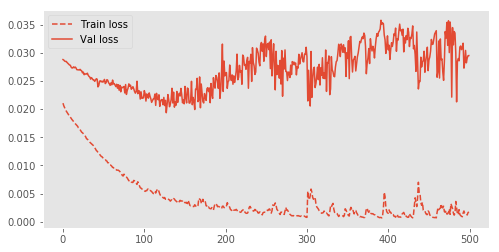

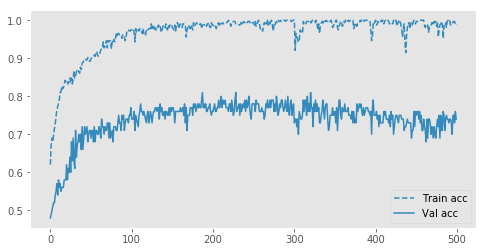

In [60]:
plot_learning_curves(train_losses, val_losses, train_accs, val_accs)

In [63]:
train_input_var = Variable(train_input.cuda())
train_target_var = Variable(train_target.cuda(), requires_grad=False)

test_input_var = Variable(test_input.cuda())
test_target_var = Variable(test_target.cuda(), requires_grad=False)

In [66]:
pred_test = best_model(test_input_var).data
pred_test_classes = pred_test.max(1)[1]
accuracy_score(pred_test_classes, test_target)

/home/roman/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


0.81000000000000005

In [67]:
pred_train = best_model(train_input_var).data
pred_train_classes = pred_train.max(1)[1]
accuracy_score(pred_train_classes, train_target)

/home/roman/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().


0.990506329113924